In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))

from log_processing import from_csv

In [9]:
round = 1

a0, t0 = from_csv(round, 0, dir="../../data")
a1, t1 = from_csv(round, 1, dir="../../data")
a2, t2 = from_csv(round, 2, dir="../../data")

In [10]:
PRODUCT = "SQUID_INK"
# Filter activities and trades for the specific product
act0 = a0[a0["product"] == PRODUCT]
tra0 = t0[t0["symbol"] == PRODUCT]

act1 = a1[a1["product"] == PRODUCT]
tra1 = t1[t1["symbol"] == PRODUCT]

act2 = a2[a2["product"] == PRODUCT]
tra2 = t2[t2["symbol"] == PRODUCT]

In [11]:
mid0 = act0["mid_price"].values
mid1 = act1["mid_price"].values
mid2 = act2["mid_price"].values

vwaps = []

for day in [act0, act1, act2]:
    b1 = day["bid_price_1"].fillna(0)
    b2 = day["bid_price_2"].fillna(0)
    b3 = day["bid_price_3"].fillna(0)
    vb1 = day["bid_volume_1"].fillna(0)
    vb2 = day["bid_volume_2"].fillna(0)
    vb3 = day["bid_volume_3"].fillna(0)

    vwap_bid = (
        (b1 * vb1 + b2 * vb2 + b3 * vb3) / (vb1 + vb2 + vb3)
    )

    a1 = day["ask_price_1"].fillna(0)
    a2 = day["ask_price_2"].fillna(0)
    a3 = day["ask_price_3"].fillna(0)
    va1 = day["ask_volume_1"].fillna(0)
    va2 = day["ask_volume_2"].fillna(0)
    va3 = day["ask_volume_3"].fillna(0)

    vwap_ask = (
        (a1 * va1 + a2 * va2 + a3 * va3) / (va1 + va2 + va3)
    )
    vwap = (vwap_bid + vwap_ask) / 2
    vwaps.append(vwap)

t0 = act0["timestamp"].values
t1 = act1["timestamp"].values
t2 = act2["timestamp"].values

vwap0 = vwaps[0].values
vwap1 = vwaps[1].values
vwap2 = vwaps[2].values

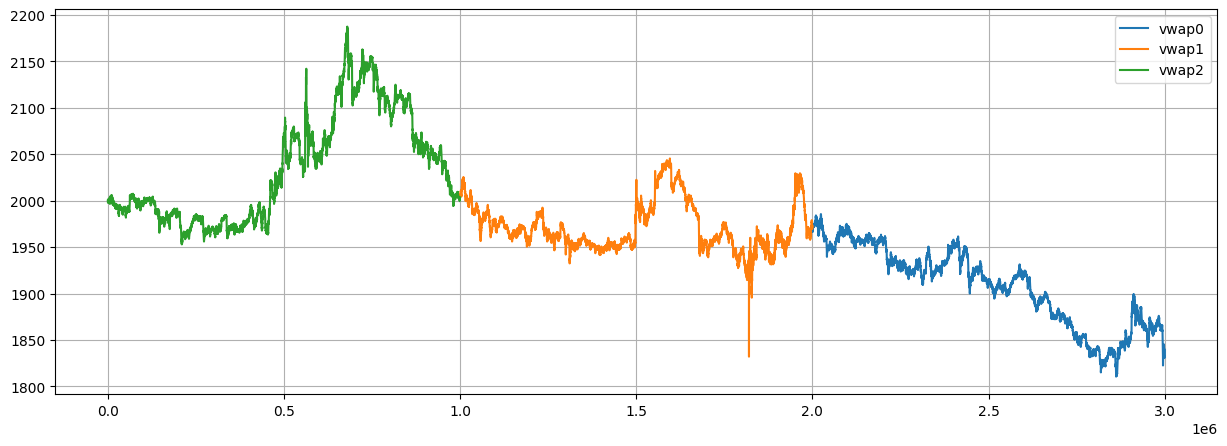

In [12]:
t1s = t2[-1] + t1
t0s = t1s[-1] + t0

plt.figure(figsize=(15, 5))
plt.plot(t0s, vwap0, label="vwap0")
plt.plot(t1s, vwap1, label="vwap1")
plt.plot(t2, vwap2, label="vwap2")
plt.grid()
plt.legend()

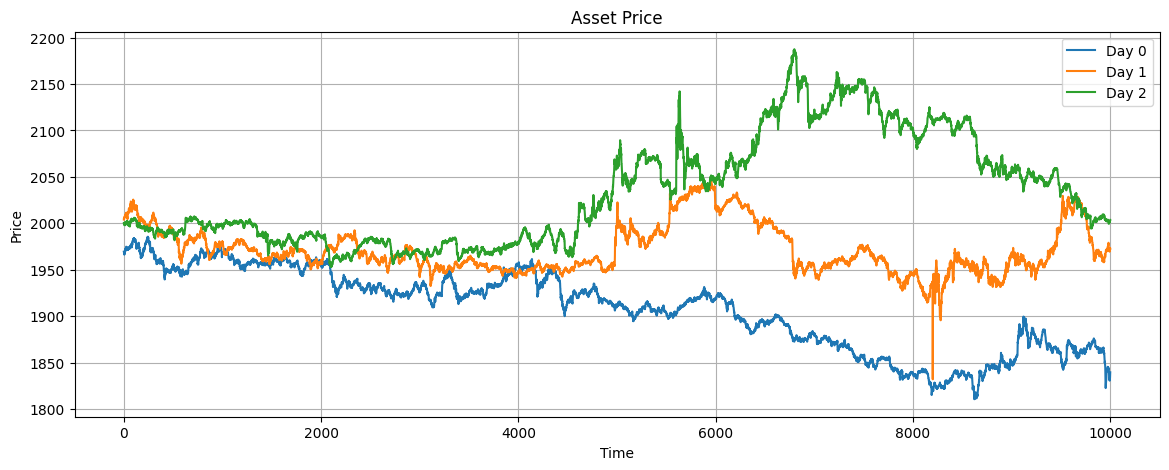

In [6]:
plt.figure(figsize=(14, 5))
plt.plot(vwap0, label="Day 0")
plt.plot(vwap1, label="Day 1")
plt.plot(vwap2, label="Day 2")
plt.title("Asset Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()

In [76]:
vwap0 = vwap0.values
vwap1 = vwap1.values
vwap2 = vwap2.values

analyze_window = slice(0, 900)
vwap0 = vwap0[analyze_window]
vwap1 = vwap1[analyze_window]
vwap2 = vwap2[analyze_window]

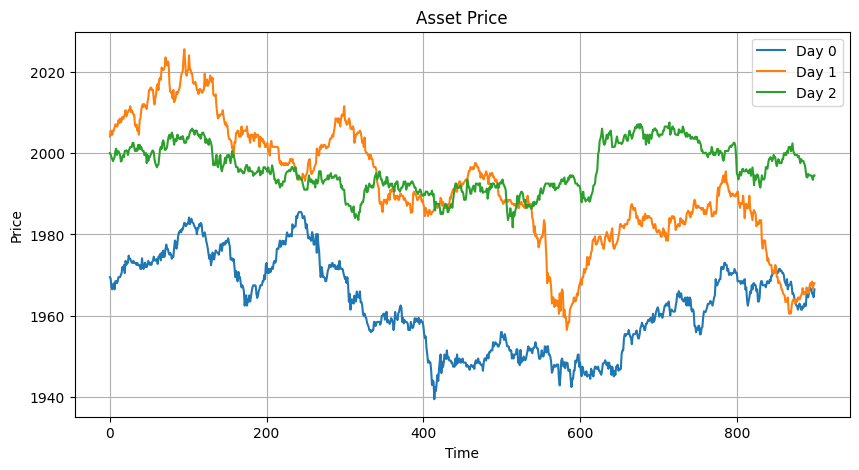

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(vwap0, label="Day 0")
plt.plot(vwap1, label="Day 1")
plt.plot(vwap2, label="Day 2")
plt.title("Asset Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()

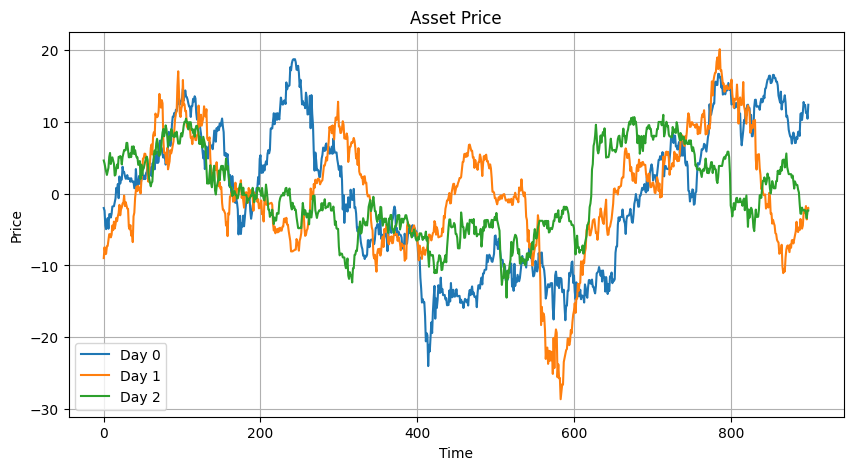

In [79]:
from scipy import signal

detrended_vwap0 = signal.detrend(vwap0)
detrended_vwap1 = signal.detrend(vwap1)
detrended_vwap2 = signal.detrend(vwap2)
plt.figure(figsize=(10, 5))
plt.plot(detrended_vwap0, label="Day 0")
plt.plot(detrended_vwap1, label="Day 1")
plt.plot(detrended_vwap2, label="Day 2")
plt.title("Asset Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()

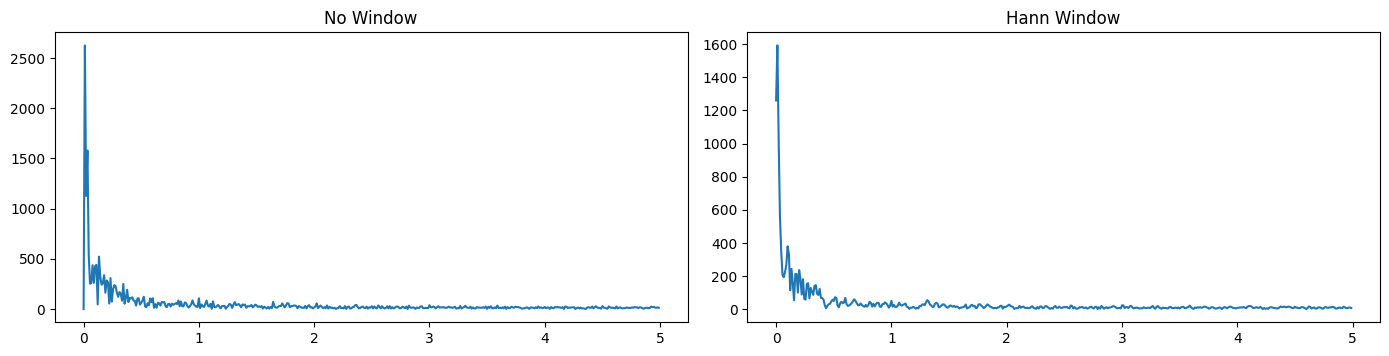

In [80]:
original_data = vwap2
detrended_data = detrended_vwap2

dt = 0.1 # Time step
fs = 1 / dt  # Sampling frequency

# Apply different window functions and compare
plt.figure(figsize=(14, 10))

# Original detrended data
plt.subplot(321)
fft_original = np.fft.fft(detrended_data)
freqs = np.fft.fftfreq(len(detrended_data), d=dt)
plt.plot(freqs[:len(freqs)//2], np.abs(fft_original)[:len(freqs)//2])
plt.title('No Window')

# Hann window
plt.subplot(322)
window = signal.windows.hann(len(detrended_data))
windowed_data = detrended_data * window
fft_hann = np.fft.fft(windowed_data)
freqs = np.fft.fftfreq(len(windowed_data), d=dt) 
plt.plot(freqs[:len(freqs)//2], np.abs(fft_hann)[:len(freqs)//2])
plt.title('Hann Window')

plt.tight_layout()

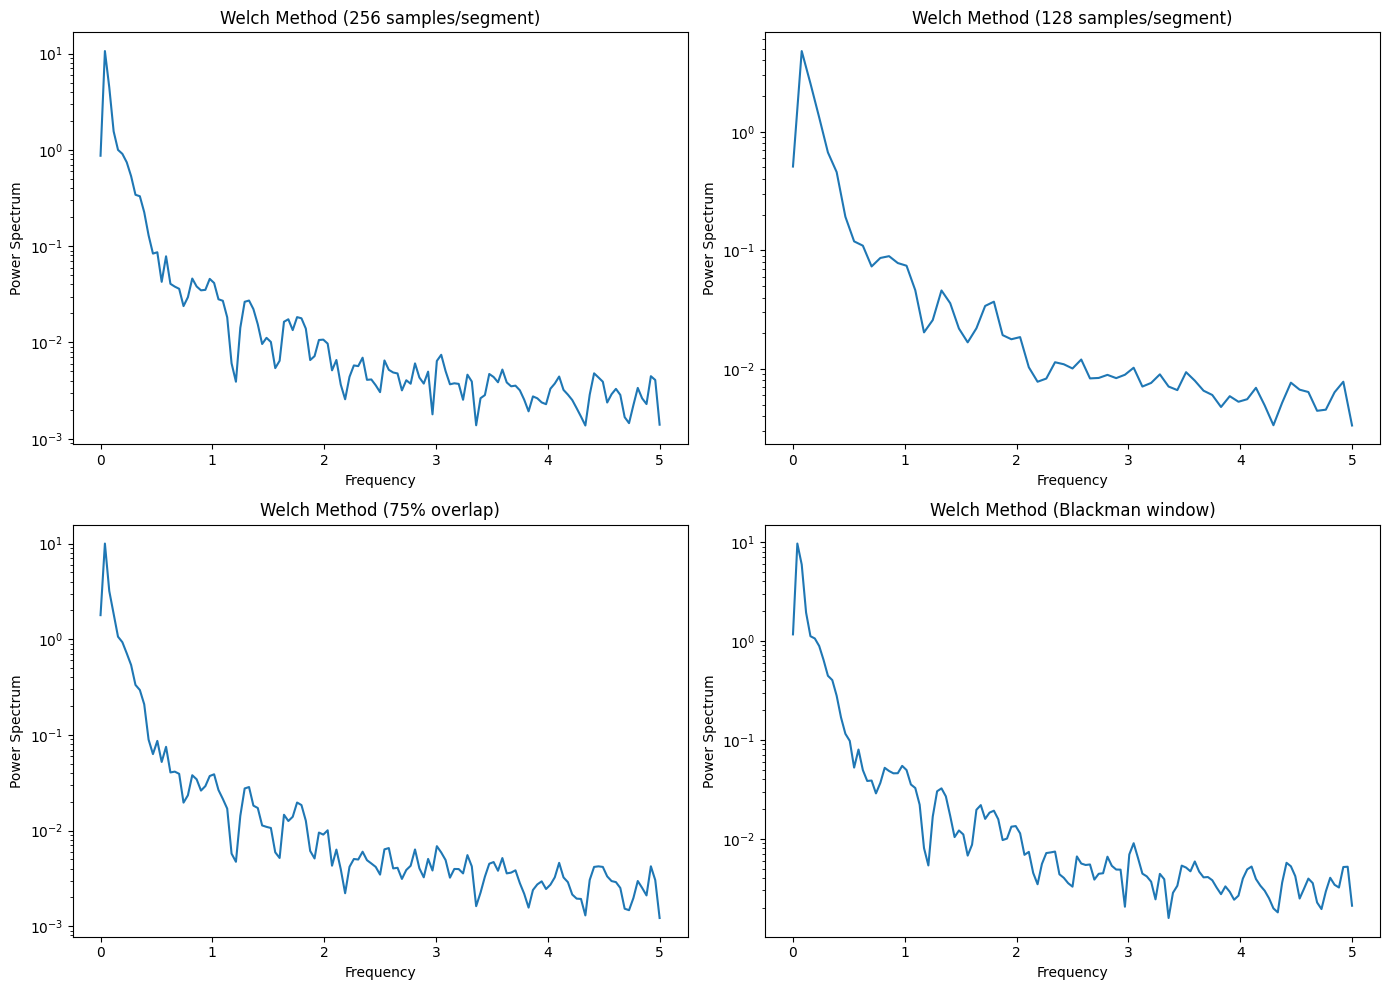

In [81]:

plt.figure(figsize=(14, 10))

# Basic Welch's method implementation
plt.subplot(221)
freqs_welch, psd_welch = signal.welch(detrended_data, fs=fs, nperseg=256, 
                                     window='hann', scaling='spectrum')
plt.semilogy(freqs_welch, psd_welch)
plt.title('Welch Method (256 samples/segment)')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')

# Try different segment lengths
plt.subplot(222)
freqs_welch2, psd_welch2 = signal.welch(detrended_data, fs=fs, nperseg=128, 
                                       window='hann', scaling='spectrum')
plt.semilogy(freqs_welch2, psd_welch2)
plt.title('Welch Method (128 samples/segment)')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')

# Try different overlap
plt.subplot(223)
freqs_welch3, psd_welch3 = signal.welch(detrended_data, fs=fs, nperseg=256, 
                                       noverlap=192, window='hann', 
                                       scaling='spectrum')
plt.semilogy(freqs_welch3, psd_welch3)
plt.title('Welch Method (75% overlap)')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')

# Compare with a different window
plt.subplot(224)
freqs_welch4, psd_welch4 = signal.welch(detrended_data, fs=fs, nperseg=256, 
                                       window='blackman', scaling='spectrum')
plt.semilogy(freqs_welch4, psd_welch4)
plt.title('Welch Method (Blackman window)')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')

plt.tight_layout()

Top peaks from Welch's method:
  Peak 1: Frequency = 0.0391 Hz, Period = 25.60 seconds
  Peak 2: Frequency = 0.5078 Hz, Period = 1.97 seconds
  Peak 3: Frequency = 0.5859 Hz, Period = 1.71 seconds
  Peak 4: Frequency = 0.8203 Hz, Period = 1.22 seconds
  Peak 5: Frequency = 0.9766 Hz, Period = 1.02 seconds
  Peak 6: Frequency = 1.3281 Hz, Period = 0.75 seconds
  Peak 7: Frequency = 1.7578 Hz, Period = 0.57 seconds
  Peak 8: Frequency = 1.6797 Hz, Period = 0.60 seconds
  Peak 9: Frequency = 1.4844 Hz, Period = 0.67 seconds
  Peak 10: Frequency = 1.9922 Hz, Period = 0.50 seconds

Top peaks from FFT:
  Peak 1: Frequency = 0.1000 Hz, Period = 10.00 seconds
  Peak 2: Frequency = 0.1333 Hz, Period = 7.50 seconds
  Peak 3: Frequency = 0.2000 Hz, Period = 5.00 seconds
  Peak 4: Frequency = 0.1667 Hz, Period = 6.00 seconds
  Peak 5: Frequency = 0.2333 Hz, Period = 4.29 seconds
  Peak 6: Frequency = 0.2778 Hz, Period = 3.60 seconds
  Peak 7: Frequency = 0.3444 Hz, Period = 2.90 seconds
  Peak 8: 

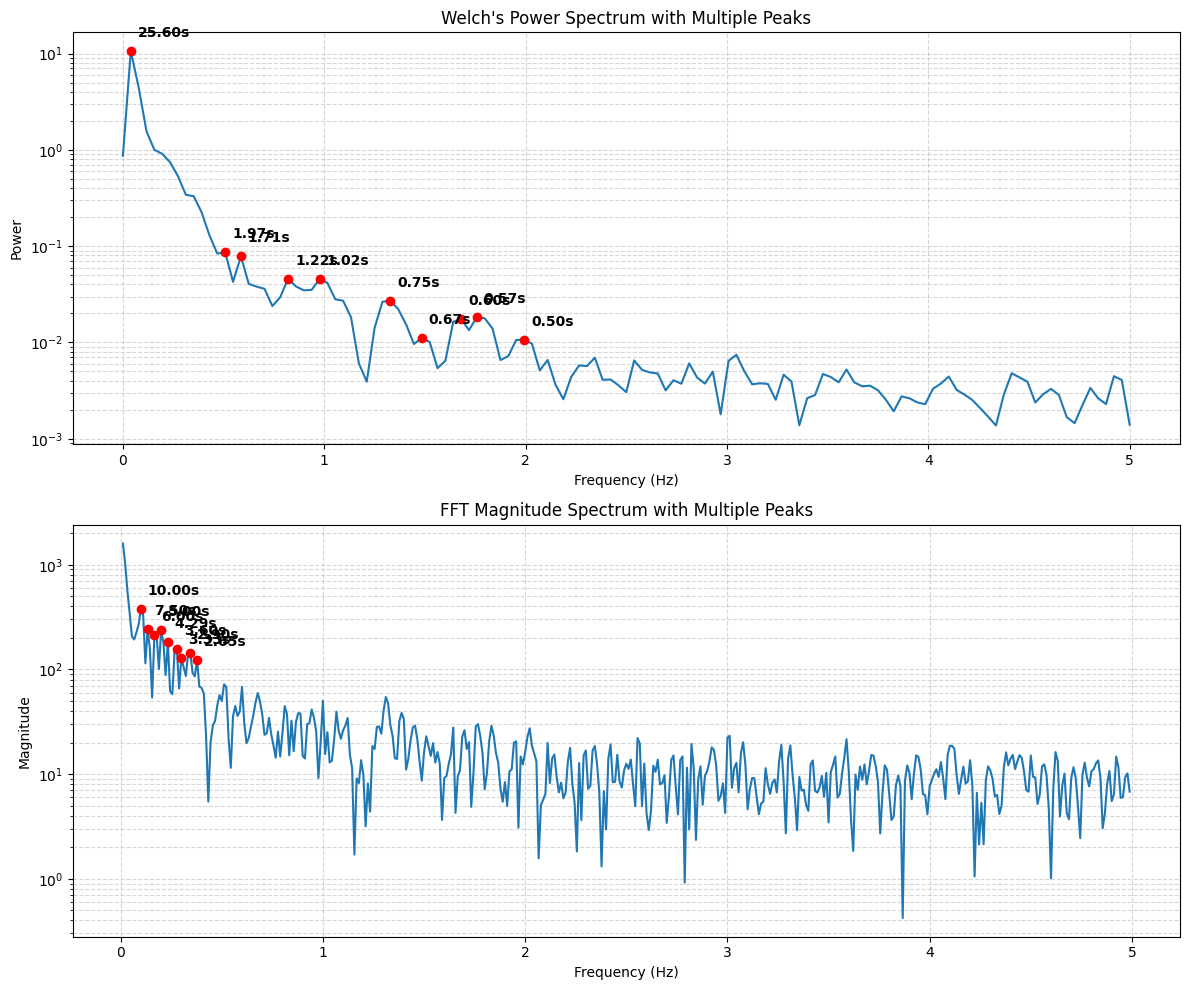

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import find_peaks


# Welch's method with correct sampling frequency
freqs_welch, psd_welch = signal.welch(detrended_data, fs=fs, nperseg=256,
                                     window='hann', scaling='spectrum')

# Find multiple peaks in Welch's PSD
peaks_welch, _ = find_peaks(psd_welch, height=np.max(psd_welch)*0.001, distance=1)
peak_powers = psd_welch[peaks_welch]
sorted_indices = np.argsort(peak_powers)[::-1]
sorted_peaks_welch = peaks_welch[sorted_indices]

# Get top peaks from Welch's method
top_welch_freqs = freqs_welch[sorted_peaks_welch]
top_welch_periods = 1/top_welch_freqs

print("Top peaks from Welch's method:")
for i, (freq, period) in enumerate(zip(top_welch_freqs, top_welch_periods)):
    print(f"  Peak {i+1}: Frequency = {freq:.4f} Hz, Period = {period:.2f} seconds")

# FFT analysis with correct sampling interval
window = signal.windows.hann(len(detrended_data))
windowed_data = detrended_data * window
fft_result = np.fft.fft(windowed_data)
freqs = np.fft.fftfreq(len(windowed_data), d=dt) 

# Only analyze positive frequencies
positive_freq_idx = np.arange(1, len(freqs)//2)
fft_magnitudes = np.abs(fft_result[positive_freq_idx])
positive_freqs = freqs[positive_freq_idx]

# Find multiple peaks in FFT spectrum
peaks_fft, _ = find_peaks(fft_magnitudes, height=np.max(fft_magnitudes)*0.075, distance=1)
peak_mags = fft_magnitudes[peaks_fft]
sorted_indices = np.argsort(peak_mags)[::-1]
sorted_peaks_fft = peaks_fft[sorted_indices]

# Get top peaks from FFT
top_fft_freqs = positive_freqs[sorted_peaks_fft]
top_fft_periods = 1/top_fft_freqs

print("\nTop peaks from FFT:")
for i, (freq, period) in enumerate(zip(top_fft_freqs, top_fft_periods)):
    print(f"  Peak {i+1}: Frequency = {freq:.4f} Hz, Period = {period:.2f} seconds")

# Create visualizations
plt.figure(figsize=(12, 10))

# Welch's method visualization
plt.subplot(211)
plt.semilogy(freqs_welch, psd_welch)
plt.plot(top_welch_freqs, psd_welch[sorted_peaks_welch], 'ro')

# Annotate peaks with periods
for i, (freq, period) in enumerate(zip(top_welch_freqs, top_welch_periods)):
    plt.annotate(f"{period:.2f}s", 
                xy=(freq, psd_welch[sorted_peaks_welch[i]]),
                xytext=(5, 10), textcoords='offset points',
                fontweight='bold')

plt.title("Welch's Power Spectrum with Multiple Peaks")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# FFT visualization
plt.subplot(212)
plt.semilogy(positive_freqs, fft_magnitudes)
plt.plot(top_fft_freqs, fft_magnitudes[sorted_peaks_fft], 'ro')

# Annotate peaks with periods
for i, (freq, period) in enumerate(zip(top_fft_freqs, top_fft_periods)):
    plt.annotate(f"{period:.2f}s", 
                xy=(freq, fft_magnitudes[sorted_peaks_fft[i]]),
                xytext=(5, 10), textcoords='offset points',
                fontweight='bold')

plt.title('FFT Magnitude Spectrum with Multiple Peaks')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()

In [86]:
from scipy.optimize import curve_fit

t = np.arange(0, len(detrended_data) * dt, dt)  # Time axis in seconds

# Get all frequencies from peaks, not just top ones
# all_peak_freqs = freqs[peaks_fft]
all_peak_freqs = freqs_welch[peaks_welch]  # All detected peaks
all_peak_periods = 1/all_peak_freqs

print(f"Fitting model with {len(all_peak_freqs)} frequency components")

# Define model with all detected frequencies
def sinusoid_model(t, *params):
    result = np.zeros_like(t)
    for i in range(len(params)//2):
        A = params[i*2]       # Amplitude
        phi = params[i*2+1]   # Phase
        freq = all_peak_freqs[i]
        result += A * np.sin(2 * np.pi * freq * t + phi)
    return result

# Initial guesses (amplitudes and phases)
initial_guesses = []
for i in range(len(all_peak_freqs)):
    # Decreasing amplitude guesses based on peak order
    amplitude_guess = np.std(detrended_data) * (0.8**i)
    initial_guesses.extend([amplitude_guess, 0])  # [A1, phi1, A2, phi2, ...]

# Add safeguard for large number of parameters
max_freqs = min(len(all_peak_freqs), 10)  # Limit to 10 frequencies if there are too many
if len(all_peak_freqs) > max_freqs:
    print(f"Warning: Limiting to {max_freqs} frequencies for stable fitting")
    all_peak_freqs = all_peak_freqs[:max_freqs]
    all_peak_periods = all_peak_periods[:max_freqs]
    initial_guesses = initial_guesses[:max_freqs*2]

try:
    # Fit the model to the data
    params, covariance = curve_fit(sinusoid_model, t, detrended_data, p0=initial_guesses, 
                                  maxfev=10000)  # Increase max iterations
    
    # Extract the fitted amplitudes and phases
    fitted_amplitudes = [params[i*2] for i in range(len(params)//2)]
    fitted_phases = [params[i*2+1] for i in range(len(params)//2)]
    
    # Sort results by amplitude (highest first)
    results = sorted(zip(all_peak_freqs, all_peak_periods, fitted_amplitudes, fitted_phases), 
                    key=lambda x: abs(x[2]), reverse=True)
    
    print("\nCurve fitting results (sorted by amplitude):")
    for i, (freq, period, amplitude, phase) in enumerate(results):
        print(f"Component {i+1}: Frequency = {freq:.4f} Hz, Period = {period:.2f}s, " 
              f"Amplitude = {amplitude:.6f}, Phase = {phase:.4f}")
    
    # Calculate fit quality
    predicted = sinusoid_model(t, *params)
    r_squared = 1 - (np.sum((detrended_data - predicted)**2) / np.sum((detrended_data - np.mean(detrended_data))**2))
    print(f"\nFit quality: R² = {r_squared:.4f}")
    
except Exception as e:
    print(f"Error in curve fitting: {e}")
    print("Try reducing the number of frequencies or adjusting initial parameters")

Fitting model with 10 frequency components

Curve fitting results (sorted by amplitude):
Component 1: Frequency = 0.0391 Hz, Period = 25.60s, Amplitude = -1.556299, Phase = 0.9618
Component 2: Frequency = 0.8203 Hz, Period = 1.22s, Amplitude = 0.182331, Phase = -0.1436
Component 3: Frequency = 0.5078 Hz, Period = 1.97s, Amplitude = 0.134842, Phase = 11.3354
Component 4: Frequency = 1.7578 Hz, Period = 0.57s, Amplitude = 0.116922, Phase = -0.5607
Component 5: Frequency = 1.3281 Hz, Period = 0.75s, Amplitude = -0.109089, Phase = -0.1165
Component 6: Frequency = 1.4844 Hz, Period = 0.67s, Amplitude = -0.055752, Phase = 0.1628
Component 7: Frequency = 0.9766 Hz, Period = 1.02s, Amplitude = 0.049926, Phase = 0.7454
Component 8: Frequency = 0.5859 Hz, Period = 1.71s, Amplitude = -0.045913, Phase = 0.4886
Component 9: Frequency = 1.6797 Hz, Period = 0.60s, Amplitude = -0.030438, Phase = 0.0310
Component 10: Frequency = 1.9922 Hz, Period = 0.50s, Amplitude = -0.030172, Phase = -0.4632

Fit qua

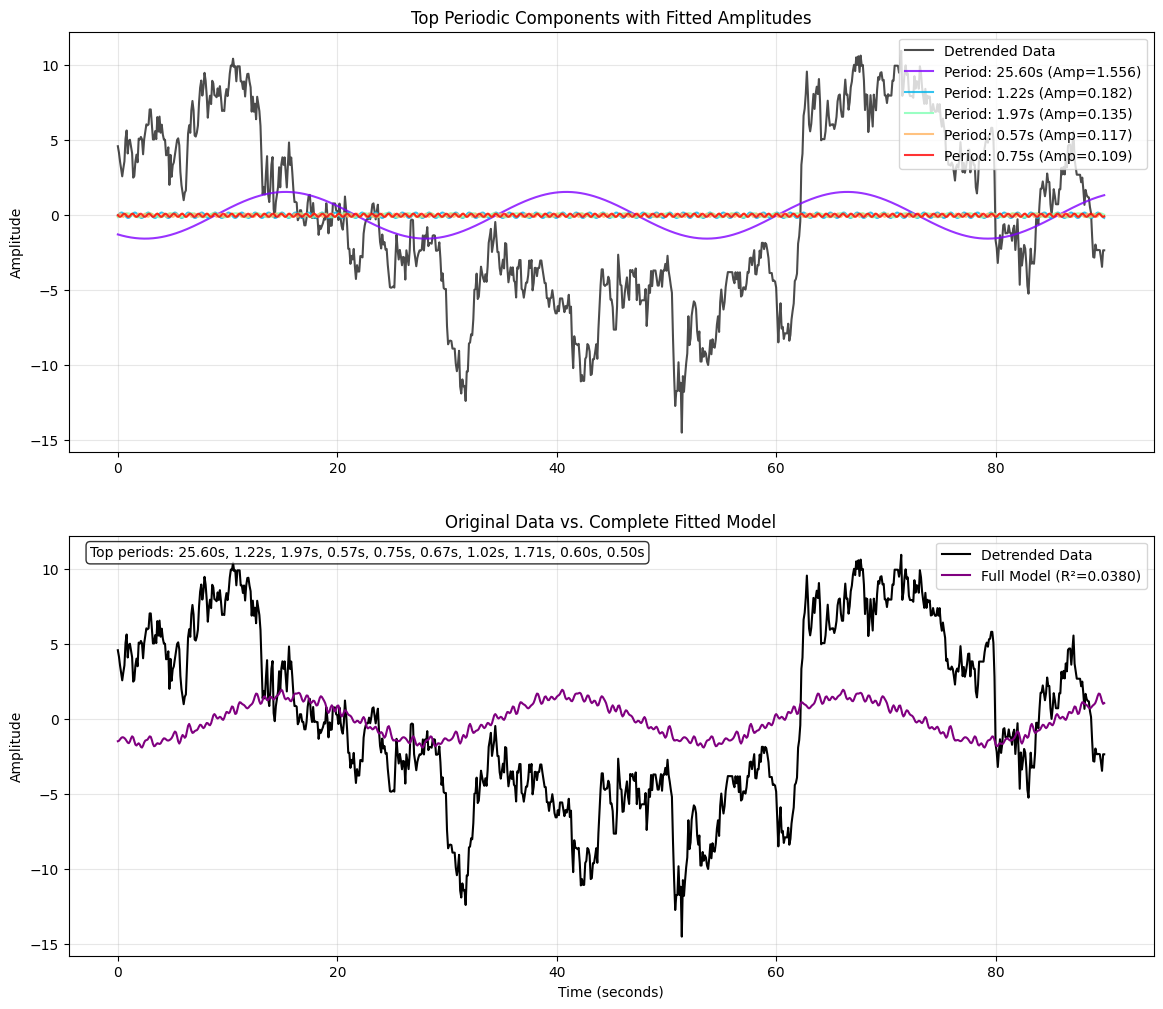

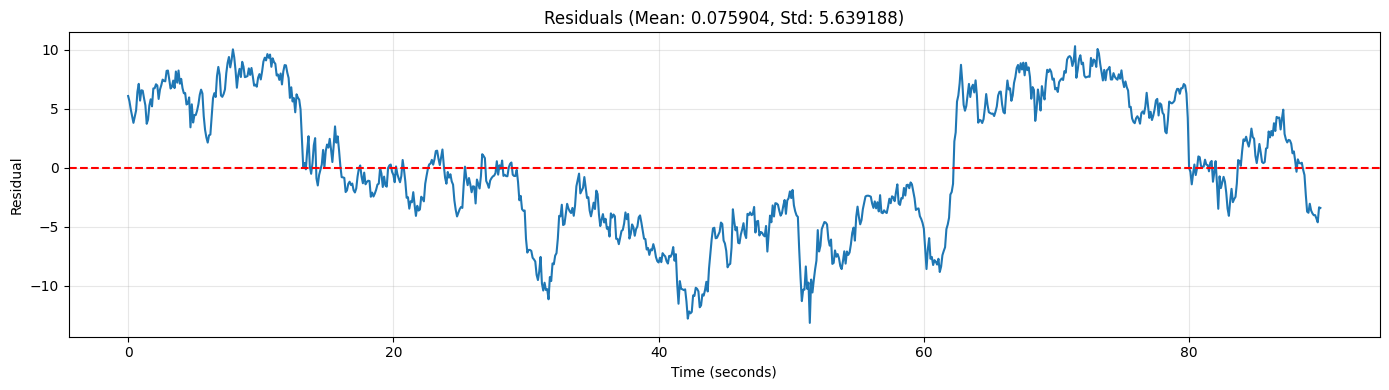

In [87]:
# Plot with correct amplitudes from our fit
plt.figure(figsize=(14, 12))

# First subplot - Original data with individual components
plt.subplot(211)
plt.plot(t, detrended_data, label='Detrended Data', color='black', alpha=0.7)

# Define a color cycle for potentially many components
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, min(len(results), 5)))  # Limit to top 5 for clarity

# Plot top components individually
combined_signal = np.zeros_like(t)
for i, (freq, period, amplitude, phase) in enumerate(results[:5]):  # Show top 5 components
    sinusoid = amplitude * np.sin(2 * np.pi * freq * t + phase)
    
    plt.plot(t, sinusoid, 
             label=f'Period: {period:.2f}s (Amp={abs(amplitude):.3f})', 
             color=colors[i], linestyle='-', alpha=0.8)
    
    # Add to combined signal
    if i < len(results):  # Add all components to the combined signal
        combined_signal += sinusoid

plt.ylabel('Amplitude')
plt.title('Top Periodic Components with Fitted Amplitudes')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Second subplot - Original vs fitted model
plt.subplot(212)
plt.plot(t, detrended_data, label='Detrended Data', color='black')

# Use the actual full model prediction from curve_fit
predicted = sinusoid_model(t, *params)
plt.plot(t, predicted, label=f'Full Model (R²={r_squared:.4f})', 
         color='purple', linewidth=1.5)

# Add text annotation listing top periods
periods_text = ", ".join([f"{period:.2f}s" for _, period, _, _ in results])
plt.annotate(f"Top periods: {periods_text}", xy=(0.02, 0.95), xycoords='axes fraction', 
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Original Data vs. Complete Fitted Model')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Optional third subplot - Residuals
plt.figure(figsize=(14, 4))
residuals = detrended_data - predicted
plt.plot(t, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f'Residuals (Mean: {np.mean(residuals):.6f}, Std: {np.std(residuals):.6f})')
plt.xlabel('Time (seconds)')
plt.ylabel('Residual')
plt.grid(True, alpha=0.3)

plt.tight_layout()